#### TODO
- Continous integraion of latest data using https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb
- Create 3 categories only that will be used for predictions.
- Calculate TS% that will be used also for feature enginnering
- Usage Rate (USG%): This metric estimates the percentage of team plays used by a player while he is on the floor. It can be calculated using field goal attempts, free throw attempts, and turnovers in relation to the team's total attempts.

- Assist to Turnover Ratio: A simple yet effective metric showing a player's ball-handling efficiency. It's calculated by dividing the total number of assists by the number of turnovers.

- Rebounding Efficiency: This can be calculated as the total number of rebounds (offensive + defensive) divided by the minutes played. It helps in understanding a player's rebounding ability relative to their playing time.

- Shot Selection Profile: Using FG%, 3P%, and 2P%, you can analyze a player's shot selection tendencies and efficiency.

-Add a team dimension    
-Add relative scores based on numbers of the team.    
-Split and extract validation data that will not be used at all, to avoid data leakage in validation   


Sources :    
https://www.kaggle.com/code/diegobormor/nba-2022-2023-data-overview/    
https://www.kaggle.com/code/fahmisajid/player-position-classification/notebook


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RAW_DATA_DIR = Path('..') / "data" / "raw"
CURATED_DATA_DIR = Path('..') / "data" / "curated"

In [7]:
players = pd.read_csv("/Users/louisar/Documents/DevVsCode/Efrei/mlops-nba-louisar/data/full_data/2023-2024 NBA Player Stats - Regular.csv",sep= ",", encoding='Windows-1252')

In [8]:
players.sort_values(by=['Player'], ascending=True)

Rk           Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...    FT%  \
176  165       A.J. Green  SG   24  MIL  23   0   7.2  1.1   2.3  ...  1.000   
272  261      A.J. Lawson  SG   23  DAL  16   0  10.3  1.8   3.7  ...  0.714   
182  171       AJ Griffin  SF   20  ATL  13   0   9.0  0.8   2.8  ...  1.000   
172  161     Aaron Gordon  PF   28  DEN  33  33  31.5  5.5  10.2  ...  0.636   
210  199    Aaron Holiday  PG   27  HOU  34   1  18.0  2.5   5.7  ...  0.917   
..   ...              ...  ..  ...  ...  ..  ..   ...  ...   ...  ...    ...   
103   96     Zach Collins   C   26  SAS  31  23  26.1  4.9  10.0  ...  0.792   
271  260      Zach LaVine  SG   28  CHI  21  19  35.3  7.0  15.8  ...  0.853   
358  343       Zeke Nnaji  PF   23  DEN  33   0   9.9  1.2   2.5  ...  0.641   
534  511  Ziaire Williams  SF   22  MEM  35   8  18.9  2.8   6.9  ...  0.837   
535  512  Zion Williamson  PF   23  NOP  31  31  30.2  8.5  14.6  ...  0.664   

     ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
176  0.2  0.6  0.7  0.6  0.0  0.0  0.0  0.8   3.1  
272  0.5  0.9  1.4  0.6  0.6  0.1  0.5  0.8   4.8  
182  0.2  0.8  0.9  0.3  0.1  0.0  0.5  0.5   2.5  
172  2.8  3.8  6.6  3.2  0.9  0.6  1.3  1.7  13.8  
210  0.3  1.7  2.0  1.7  0.5  0.1  0.8  1.6   6.9  
..   ...  ...  ...  ...  ...  ...  ...  ...   ...  
103  1.9  4.1  6.0  3.3  0.6  0.8  2.3  3.4  12.9  
271  0.4  4.8  5.2  3.7  1.0  0.3  2.1  2.1  20.3  
358  1.2  1.1  2.2  0.5  0.2  0.6  0.6  1.6   3.3  
534  0.6  2.9  3.5  1.3  0.5  0.3  1.2  1.7   7.8  
535  1.9  4.1  5.9  4.6  1.0  0.4  2.6  2.7  21.7  

[546 rows x 30 columns]

In [9]:
assert sum(players.isnull().sum()) == 0, "There are not null values in the dataset"

In [10]:
players["EFF"] = players.PTS + players.TRB + players.AST + players.STL + players.BLK - (players.FGA - players.FG) - (players.FTA - players.FT) - players.TOV

<Axes: xlabel='Pos', ylabel='EFF'>

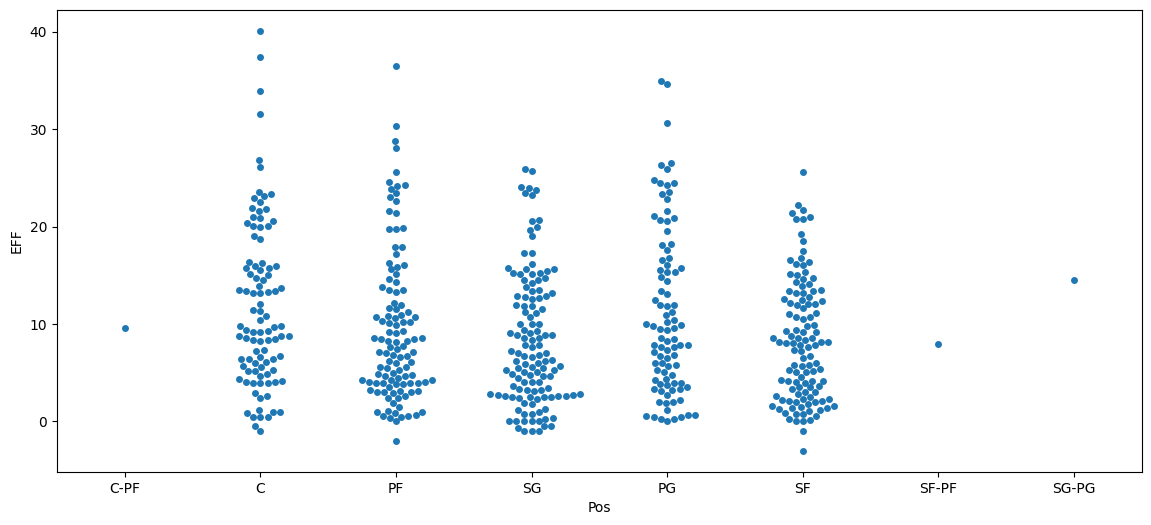

In [11]:
plt.figure(figsize=(14,6))
sns.swarmplot(
    x=players["Pos"],
    y=players["EFF"]
)

In [12]:
ages = players.Age.describe().round(decimals=1) # used to specify the first 25%, defining what is a young player
points = players.PTS.describe().round(decimals=1)

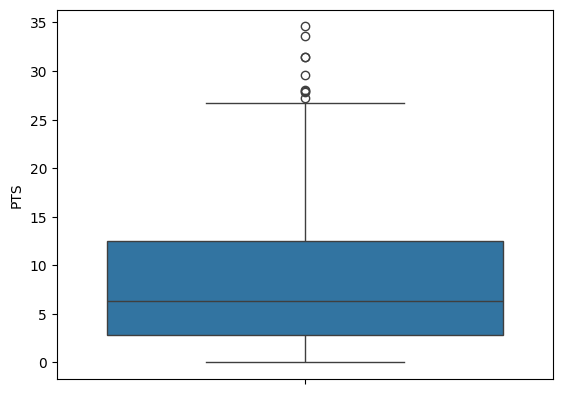

In [13]:
sns.boxplot(data=players, y="PTS");

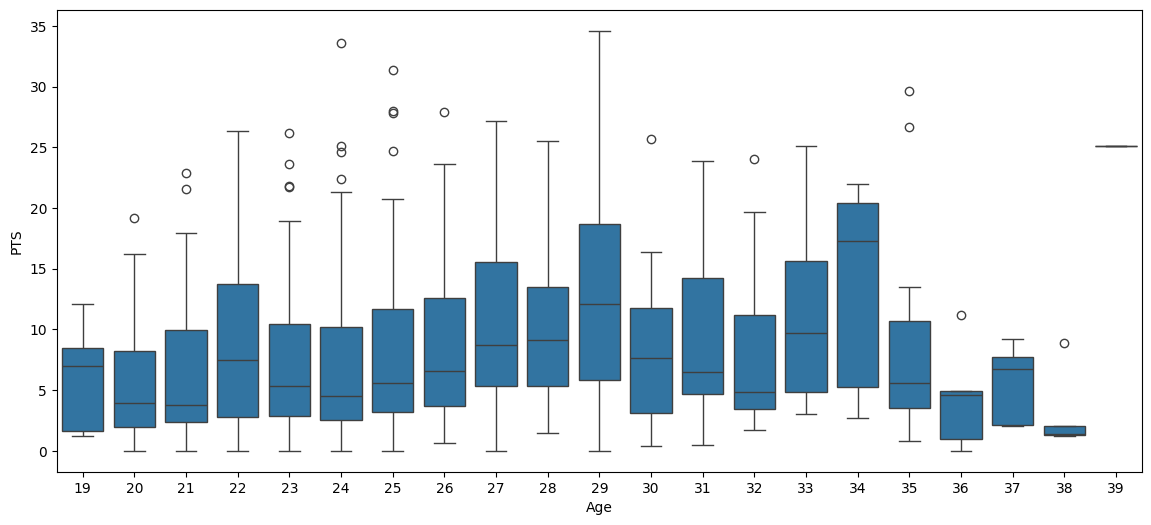

In [14]:
plt.figure(figsize=(14,6))
sns.boxplot(data=players, x="Age", y="PTS");

With the graph below, we can see that within <23y (what we have defined to be a young age), if we have more than 15 points we are special. Those data will then be used to filter the current base player and keep only special ones.

In [15]:
young_age = ages["25%"]
futur_super_star_def = f"(EFF >= 12) & (PTS >= 15) & (Age <= {young_age})"
players.query(futur_super_star_def).sort_values("EFF", ascending=False).sort_values(["Age", "EFF"], ascending=True)

Rk             Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  ORB  \
442  423     Shaedon Sharpe  SG   20  POR  31  25  33.5  5.6  13.5  ...  1.3   
515  492  Victor Wembanyama  PF   20  SAS  32  32  28.9  7.1  15.8  ...  2.1   
179  168        Jalen Green  SG   21  HOU  36  36  30.4  5.8  14.3  ...  0.4   
27    24     Paolo Banchero  PF   21  ORL  37  37  35.0  8.1  17.7  ...  1.2   
214  203      Chet Holmgren   C   21  OKC  36  36  30.1  6.7  12.1  ...  1.5   
437  418     Alperen ?engün   C   21  HOU  36  36  32.3  8.5  15.8  ...  2.6   
474  453         Cam Thomas  SG   22  BRK  28  20  28.5  7.5  17.4  ...  0.3   
526  503     Jalen Williams  PF   22  OKC  33  33  32.1  7.0  12.9  ...  0.4   
113  104    Cade Cunningham  PG   22  DET  36  36  34.5  8.5  19.0  ...  0.4   
502  479       Franz Wagner  SF   22  ORL  34  34  33.4  7.7  16.5  ...  1.1   
242  231      Jalen Johnson  SF   22  ATL  22  19  31.3  6.1  10.4  ...  1.4   
137  128    Anthony Edwards  SG   22  MIN  34  34  34.8  9.1  19.7  ...  0.7   
337  322        Evan Mobley  PF   22  CLE  21  21  33.6  6.8  11.8  ...  2.7   
25    22        LaMelo Ball  PG   22  CHO  15  15  33.4  8.8  19.9  ...  1.5   
32    29     Scottie Barnes  SG   22  TOR  38  38  35.1  7.7  16.0  ...  2.3   
34    30         RJ Barrett  SG   23  NYK  26  26  29.5  6.3  14.9  ...  0.7   
33    30         RJ Barrett  SG   23  TOT  32  32  30.1  6.6  14.7  ...  0.8   
349  334      Keegan Murray  SF   23  SAC  33  33  32.9  6.1  13.1  ...  1.4   
497  474      Devin Vassell  SG   23  SAS  31  25  30.6  6.9  14.5  ...  0.4   
518  495         Coby White  PG   23  CHI  39  39  35.4  6.5  14.6  ...  0.4   
535  512    Zion Williamson  PF   23  NOP  31  31  30.2  8.5  14.6  ...  1.9   
35    30         RJ Barrett  SG   23  TOR   6   6  33.0  8.0  13.5  ...  1.0   
310  295       Tyrese Maxey  PG   23  PHI  35  35  37.4  9.0  19.9  ...  0.6   
186  175  Tyrese Haliburton  PG   23  IND  33  33  33.4  8.4  16.9  ...  0.6   

     DRB   TRB   AST  STL  BLK  TOV   PF   PTS   EFF  
442  3.7   5.0   3.0  0.9  0.4  2.3  2.7  16.2  14.7  
515  8.1  10.2   3.1  1.2  3.2  3.1  2.3  19.2  24.2  
179  4.3   4.6   3.3  0.6  0.3  2.2  1.3  17.3  14.5  
27   5.9   7.1   4.8  1.1  0.6  3.3  2.2  22.9  21.4  
214  5.9   7.4   2.7  0.6  2.6  1.8  2.7  17.9  23.3  
437  6.4   9.0   5.0  1.2  0.7  2.5  3.4  21.6  26.1  
474  2.2   2.5   2.1  0.6  0.3  1.6  1.9  20.3  13.5  
526  3.7   4.1   4.4  1.1  0.5  1.9  2.7  18.2  19.9  
113  3.6   4.1   7.3  1.0  0.3  3.8  2.8  22.8  20.6  
502  4.8   5.9   3.9  1.1  0.4  1.9  2.3  20.9  20.8  
242  7.2   8.5   3.0  1.1  0.9  1.9  2.4  15.4  22.2  
137  4.6   5.4   4.9  1.3  0.6  3.5  1.9  26.3  23.4  
337  7.8  10.5   2.9  0.8  1.7  2.3  2.9  16.0  23.9  
25   3.9   5.5   8.2  1.4  0.3  3.9  3.5  24.7  24.5  
32   6.2   8.6   5.7  1.4  1.4  2.4  2.1  20.4  25.9  
34   3.5   4.3   2.4  0.5  0.3  1.8  1.7  18.2  14.5  
33   4.0   4.8   2.6  0.5  0.3  1.9  2.1  18.9  16.2  
349  4.2   5.5   1.6  1.2  0.5  0.9  2.6  16.2  16.8  
497  3.0   3.4   3.1  1.3  0.2  1.2  1.1  18.6  17.3  
518  4.0   4.5   4.9  0.7  0.3  2.1  2.5  18.5  18.2  
535  4.1   5.9   4.6  1.0  0.4  2.6  2.7  21.7  22.6  
35   5.8   6.8   3.5  0.7  0.2  2.5  3.5  21.8  24.0  
310  3.2   3.7   6.7  0.9  0.5  1.6  2.1  26.2  24.8  
186  3.6   4.2  12.5  1.1  0.7  2.5  1.1  23.6  30.6  

[24 rows x 31 columns]

### Age and more

<Axes: xlabel='count', ylabel='Pos'>

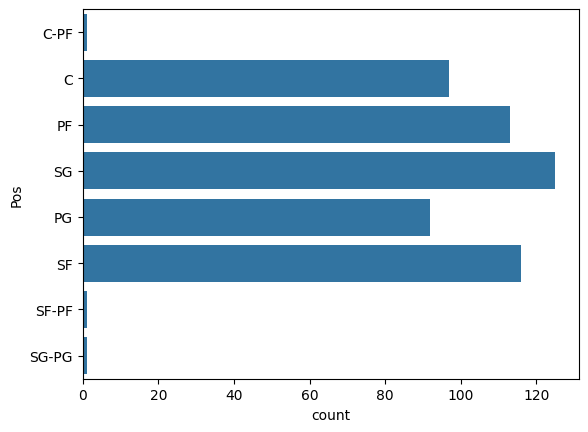

In [16]:
sns.countplot(players['Pos'],label="Count")

In [17]:
players

Rk            Player   Pos  Age   Tm   G  GS    MP   FG   FGA  ...  ORB  \
0      1  Precious Achiuwa  C-PF   24  TOT  30   0  16.6  2.8   6.2  ...  2.0   
1      1  Precious Achiuwa     C   24  TOR  25   0  17.5  3.1   6.8  ...  2.0   
2      1  Precious Achiuwa    PF   24  NYK   5   0  12.0  1.2   3.4  ...  2.0   
3      2       Bam Adebayo     C   26  MIA  27  27  34.4  8.0  15.7  ...  2.2   
4      3      Ochai Agbaji    SG   23  UTA  39  10  20.3  2.4   5.3  ...  0.8   
..   ...               ...   ...  ...  ...  ..  ..   ...  ...   ...  ...  ...   
541  518    Thaddeus Young    PF   35  TOR  10   2   8.7  1.6   2.6  ...  0.6   
542  519        Trae Young    PG   25  ATL  34  34  36.6  8.6  20.0  ...  0.4   
543  520    Omer Yurtseven     C   25  UTA  22   6  11.3  1.6   3.4  ...  1.5   
544  521       Cody Zeller     C   31  NOP  28   0   9.0  0.7   1.8  ...  1.2   
545  522       Ivica Zubac     C   26  LAC  37  37  27.2  5.4   8.2  ...  3.2   

     DRB   TRB   AST  STL  BLK  TOV   PF   PTS   EFF  
0    3.1   5.1   1.5  0.6  0.5  1.0  1.5   6.9   9.6  
1    3.4   5.4   1.8  0.6  0.5  1.2  1.6   7.7  10.4  
2    1.6   3.6   0.4  0.2  0.6  0.4  1.0   2.6   4.8  
3    8.1  10.4   4.0  1.1  1.0  2.5  2.4  22.1  26.8  
4    1.7   2.5   1.0  0.6  0.5  0.7  1.5   6.1   7.0  
..   ...   ...   ...  ...  ...  ...  ...   ...   ...  
541  1.0   1.6   1.4  0.7  0.1  0.7  0.8   3.4   5.3  
542  2.6   3.0  11.0  1.4  0.2  4.3  2.0  27.8  26.5  
543  2.9   4.4   0.6  0.2  0.5  1.0  1.5   3.7   6.4  
544  1.6   2.8   1.1  0.1  0.1  0.4  1.3   2.1   4.2  
545  6.5   9.7   1.3  0.2  1.4  1.2  2.9  12.5  20.1  

[546 rows x 31 columns]

### True Shot percentage

In [18]:
players['TS%'] = np.where((2 * (players['FGA'] + 0.44 * players['FTA'])) != 0, players['PTS'] / (2 * (players['FGA'] + 0.44 * players['FTA'])), 0)

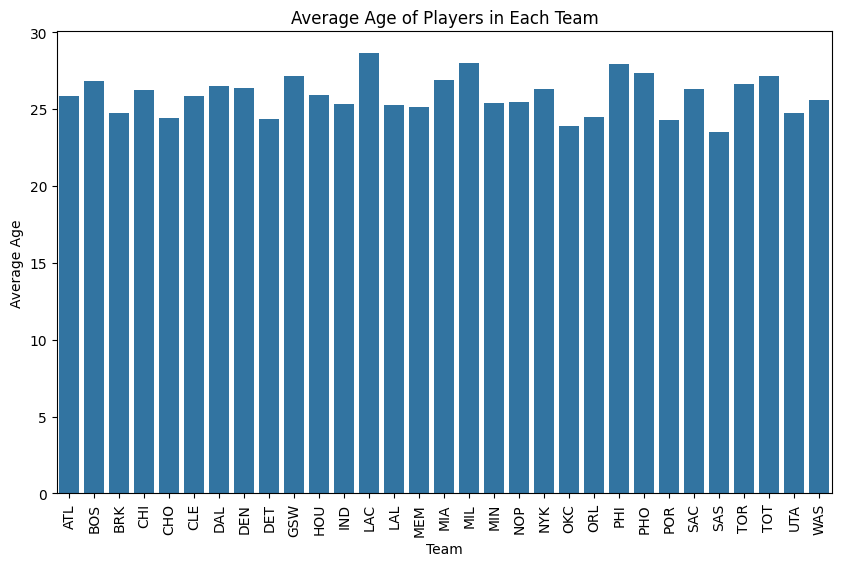

In [19]:
average_age_per_team = players.groupby('Tm')['Age'].mean()
plt.figure(figsize=(10,6))
sns.barplot(x=average_age_per_team.index, y=average_age_per_team.values)
plt.title('Average Age of Players in Each Team')
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Average Age')
plt.show()

In [20]:
players.Pos.value_counts()

Pos
SG       125
SF       116
PF       113
C         97
PG        92
C-PF       1
SF-PF      1
SG-PG      1
Name: count, dtype: int64

In [21]:
players["position"] = players.Pos.map({"PG": "Backcourt", "SG": "Backcourt", "SF": "Wing", "SF-PF": "Wing", "PF": "Big", "C": "Big", })

<Axes: xlabel='position'>

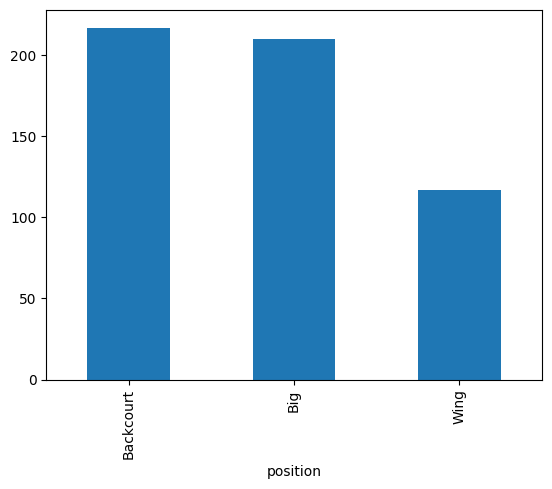

In [22]:
players.position.value_counts().plot(kind='bar')

Normalize and run a base model

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [32]:

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Pos', 'Tm'])
    ])
# Define model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])


In [33]:
# Split data into training and test sets
X = players.drop(['Player', 'PTS', 'FG%'], axis=1)
y_pts = players['PTS']
y_fg = players['FG%']
X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(X, y_pts, test_size=0.2, random_state=42)
X_train_fg, X_test_fg, y_train_fg, y_test_fg = train_test_split(X, y_fg, test_size=0.2, random_state=42)


In [34]:
# Train model to predict PTS
model.fit(X_train_pts, y_train_pts)
pts_preds = model.predict(X_test_pts)
print(f'RMSE for PTS prediction: {mean_squared_error(y_test_pts, pts_preds, squared=False)}')


RMSE for PTS prediction: 0.856134844943993


In [35]:

# Train model to predict FG%
model.fit(X_train_fg, y_train_fg)
fg_preds = model.predict(X_test_fg)
print(f'RMSE for FG% prediction: {mean_squared_error(y_test_fg, fg_preds, squared=False)}')

RMSE for FG% prediction: 0.06259242458520474


In [ ]:
# Save the pts model 
import joblib
joblib.dump(model, '/Users/louisar/Documents/DevVsCode/Efrei/mlops-nba-louisar/models/pts_model.pkl')
